<a href="https://colab.research.google.com/github/lexxai/goit_python_ds_hw_09/blob/main/goit_python_ds_hw_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модуль 9. Підбір гіперпараметрів НМ

*З циклу [домашніх завдань Python Data Science](https://github.com/lexxai/goit_python_data_sciense_homework).*

# Домашнє завдання

## Про датасет Fashion-MNIST

Дану нейромережу ми будемо вивчати на датасеті Fashion-MNIST.
Fashion-MNIST - це набір даних зображень статей Zalando, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад - це зображення 28x28 у відтінках сірого, пов'язане з міткою з 10 класів. Кожен піксель приймає значення від 0 до 255.

**Label	Description**

| Label | Clothing Item | --- | Label | Clothing Item | --- | Label | Clothing Item | --- | Label | Clothing Item | --- | Label | Clothing Item |
|-------|---------------|-----|-------|---------------|-----|-------|---------------|-----|-------|---------------|-----|-------|---------------|
| 0     | T-shirt/top   |     | 2     | Pullover      |     | 4     | Coat          |     | 6     | Shirt         |     | 8     | Bag           |
| 1     | Trouser       |     | 3     | Dress         |     | 5     | Sandal        |     | 7     | Sneaker       |     | 9     | Ankle boot    |





In [34]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D
from keras import optimizers, regularizers
from keras import losses, metrics
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

## Завантажуємо датасет

In [2]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import fashion_mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 2s 0us/step


In [3]:
num_classes = 10 # загальна кількість класів
learning_rate = 0.001 # швидкість навчання нейронної мережі
num_features = x_train.shape[1] * x_train.shape[2] # кількість атрибутів вхідного вектора 28 * 28 = 784
num_features

784

In [4]:
labels = ['T-shirt/top', 'Trouser', "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
labels_uk = ["Футболка/топ", "Штани", "Пуловер", "Сукня", "Пальто", "Босоніжки", "Сорочка", "Кросівки", "Сумка", "Черевики"]

In [5]:
# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

In [6]:
x_train.shape[1:]

(28, 28)

## Створення моделі

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


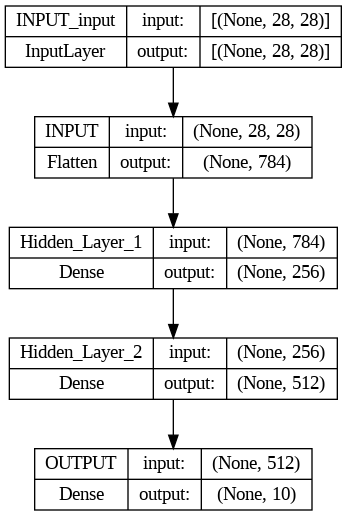

In [7]:
n_hidden_1 = 256 # кількість нейронів 1-го шару
n_hidden_2 = 512 # кількість нейронів 2-го шару
n_hidden_3 = 16 # кількість нейронів 3-го шару

kernel_regularizer=regularizers.l2(0.01)

model = Sequential([
    # Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
    # MaxPooling2D(2, 2),
    # Flatten(),
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=kernel_regularizer, name="Hidden_Layer_2"),
    # Dense(n_hidden_3, activation='relu', name="Hidden_Layer_3"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"]
)

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Навчання моделі

In [8]:
batch_size = 600 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
epochs = 19

history = model.fit(
    x_train,
    y_train,
    initial_epoch=0,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    use_multiprocessing=True
)


Epoch 1/19
100/100 [==============================] - 13s 61ms/step - loss: 2.0661 - accuracy: 0.7825 - val_loss: 1.0149 - val_accuracy: 0.8305
Epoch 2/19
100/100 [==============================] - 5s 52ms/step - loss: 0.7756 - accuracy: 0.8444 - val_loss: 0.6533 - val_accuracy: 0.8432
Epoch 3/19
100/100 [==============================] - 3s 32ms/step - loss: 0.5681 - accuracy: 0.8549 - val_loss: 0.5457 - val_accuracy: 0.8492
Epoch 4/19
100/100 [==============================] - 3s 29ms/step - loss: 0.4819 - accuracy: 0.8637 - val_loss: 0.4900 - val_accuracy: 0.8539
Epoch 5/19
100/100 [==============================] - 3s 29ms/step - loss: 0.4417 - accuracy: 0.8681 - val_loss: 0.4742 - val_accuracy: 0.8487
Epoch 6/19
100/100 [==============================] - 3s 34ms/step - loss: 0.4135 - accuracy: 0.8734 - val_loss: 0.4335 - val_accuracy: 0.8635
Epoch 7/19
100/100 [==============================] - 4s 38ms/step - loss: 0.3911 - accuracy: 0.8778 - val_loss: 0.4279 - val_accuracy: 0.865

## Аналіз результатів

In [9]:
results = model.evaluate(x_test, y_test, verbose=True)
print(results)

313/313 [==============================] - 1s 3ms/step - loss: 0.3601 - accuracy: 0.8849
[0.3601117432117462, 0.8848999738693237]


In [10]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

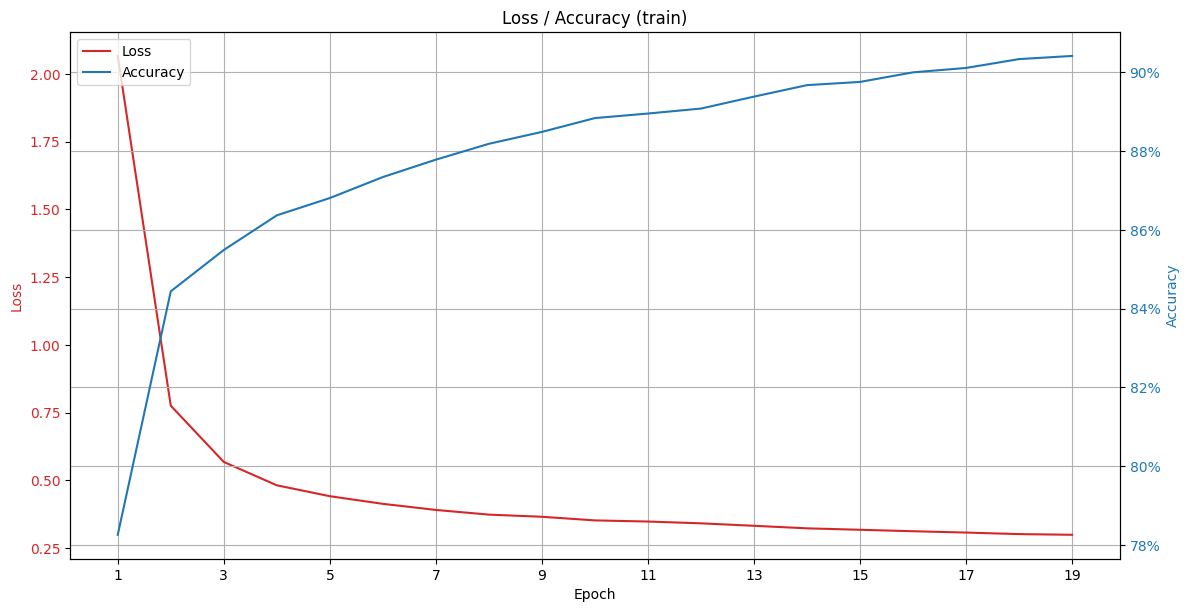

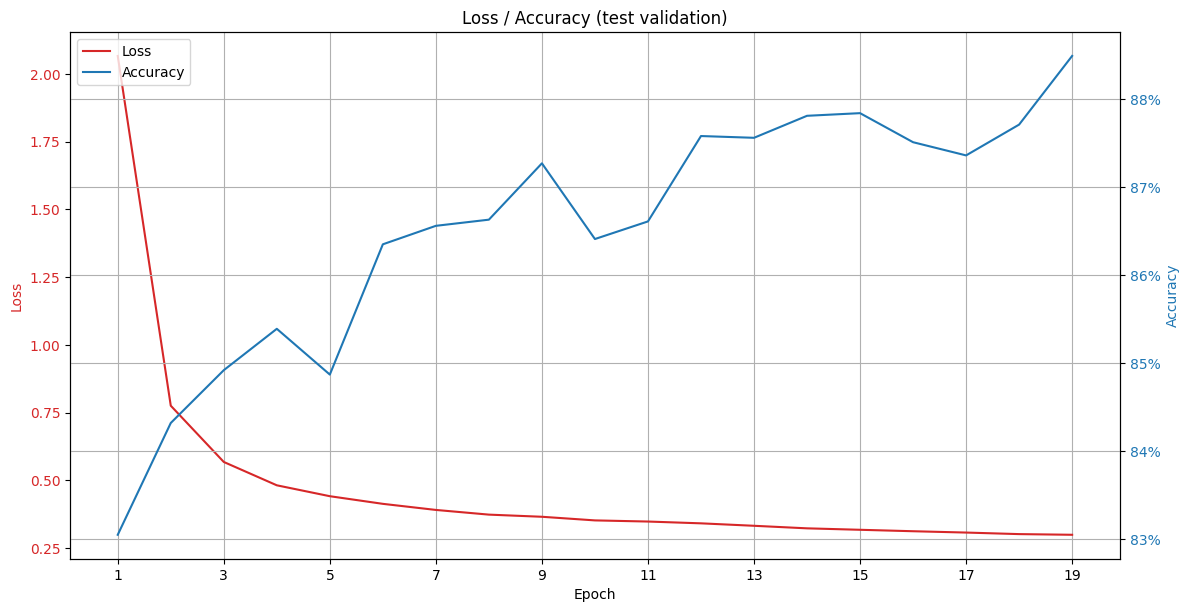

In [11]:
def pair_plot(loss_history, accuracy_history, title):
  fig, ax1 = plt.subplots()
  fig.set_size_inches((12,6))

  color = 'tab:red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(loss_history, color=color, label="Loss")
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
  ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{(y):.2f}'))
  ax1.set_xticks(np.arange(0, len(loss_history)+1, step=2))  # Set label locations.
  #ax1.legend()


  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
  p2=ax2.plot(accuracy_history, color=color, label="Accuracy")
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
  ax2.grid()
  ax1.xaxis.grid(True)

  # Combine the legends from ax1 and ax2
  lines, labels_ = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels_ + labels2, loc='best')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.title(title)
  plt.show()

loss_history = history.history['loss']
accuracy_history = history.history['accuracy']
val_loss_history = history.history['loss']
val_accuracy_history = history.history['val_accuracy']

pair_plot(loss_history, accuracy_history, "Loss / Accuracy (train)")
pair_plot(val_loss_history, val_accuracy_history, "Loss / Accuracy (test validation)")

In [12]:
test_pred = model.predict(x_test, batch_size=batch_size, use_multiprocessing=True)
test_pred.shape

17/17 [==============================] - 0s 10ms/step


(10000, 10)

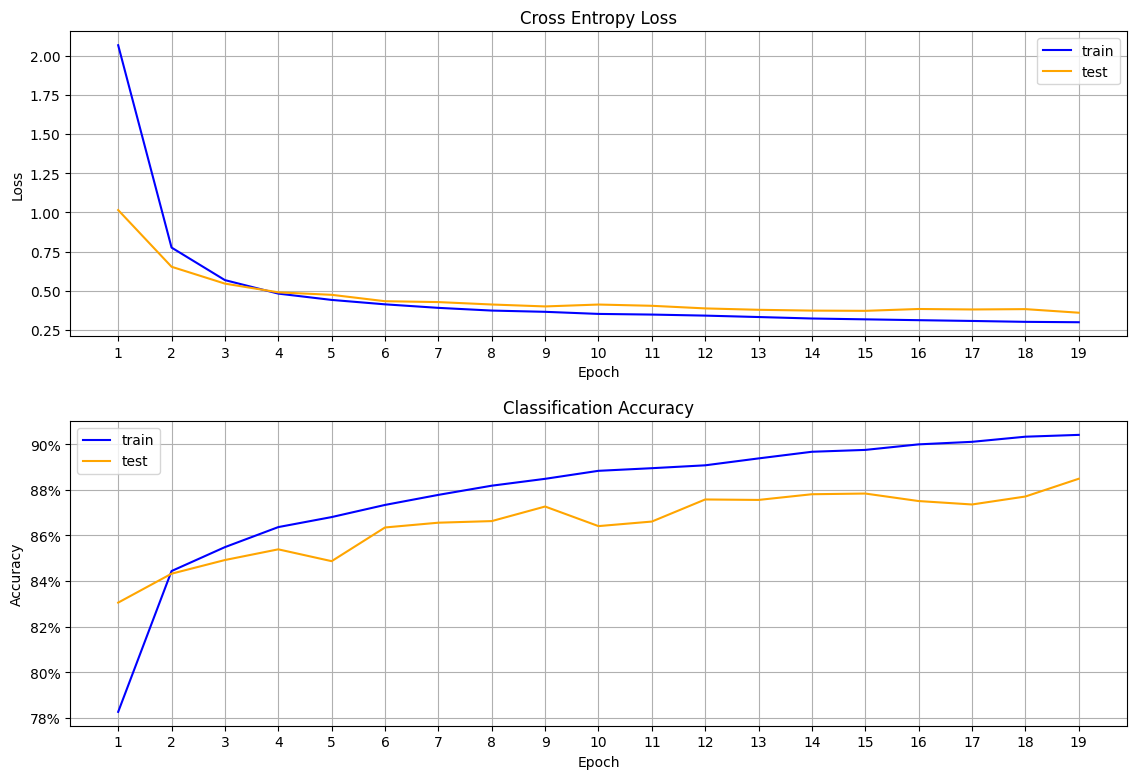

In [37]:
def summarize(histories):

  for i in range(len(histories)):
    # plot loss
    plt.figure(figsize=(12,8))
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    axis = plt.gca()
    axis.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
    axis.xaxis.set_major_locator(MultipleLocator(1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    #plt.show()
    plt.tight_layout(pad=3.0)
    # plot accuracy
    #plt.figure(figsize=(12,8))
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    axis = plt.gca()
    axis.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
    axis.xaxis.set_major_locator(MultipleLocator(1))
    axis.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()




summarize([history])

In [569]:
test_pred_values = tf.math.argmax(test_pred, axis=1)

In [570]:
target_names = [ f"{i} - {labels[i]:11}" for i in range(0, num_classes)]
print(classification_report(y_test, test_pred_values, target_names=target_names))
cr = classification_report(y_test, test_pred_values, target_names=target_names, output_dict=True)
print(cr["accuracy"])

                 precision    recall  f1-score   support

0 - T-shirt/top       0.81      0.88      0.84      1000
1 - Trouser           0.99      0.97      0.98      1000
2 - Pullover          0.84      0.74      0.79      1000
3 - Dress             0.88      0.90      0.89      1000
4 - Coat              0.72      0.90      0.80      1000
5 - Sandal            0.95      0.97      0.96      1000
6 - Shirt             0.77      0.60      0.68      1000
7 - Sneaker           0.95      0.93      0.94      1000
8 - Bag               0.97      0.97      0.97      1000
9 - Ankle boot        0.96      0.96      0.96      1000

       accuracy                           0.88     10000
      macro avg       0.88      0.88      0.88     10000
   weighted avg       0.88      0.88      0.88     10000

0.8817


In [571]:
confusion_matrix(y_test, test_pred_values)

array([[877,   1,   9,  22,   6,   3,  76,   0,   6,   0],
       [  3, 968,   0,  23,   4,   0,   1,   0,   1,   0],
       [ 25,   1, 737,  14, 166,   1,  54,   0,   2,   0],
       [ 24,   5,   8, 902,  35,   0,  22,   0,   4,   0],
       [  0,   1,  47,  29, 895,   0,  26,   0,   2,   0],
       [  0,   0,   0,   1,   0, 975,   0,  15,   2,   7],
       [156,   3,  69,  28, 131,   0, 604,   0,   9,   0],
       [  0,   0,   0,   0,   0,  34,   0, 931,   0,  35],
       [  4,   0,   3,   4,   9,   3,   3,   3, 971,   0],
       [  0,   0,   0,   0,   0,  12,   1,  30,   0, 957]])

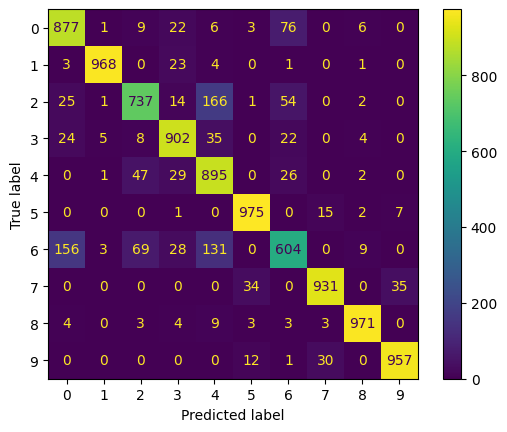

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']


In [572]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred_values)
plt.show()
print(list(map(lambda x: x.strip(),target_names)))

## Візуалізація прогнозу

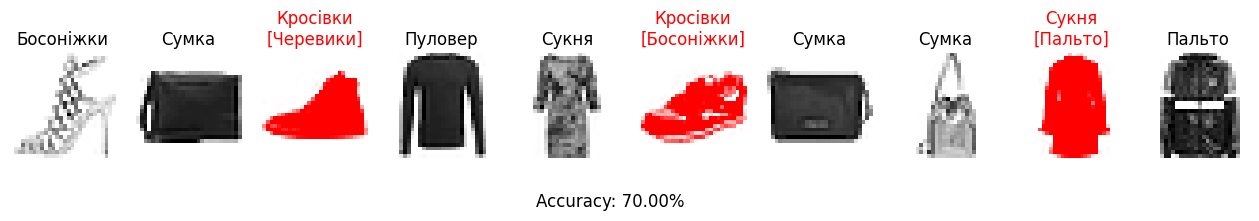

In [604]:
img_selected = 10
random_img_idx = np.random.randint(0, x_test.shape[0], size=img_selected)


# Plot the images
colors = [(1, 1, 1), (1, 0, 0), (1, 0, 0)]  # white, red, red
custom_cmap = plt.cm.colors.LinearSegmentedColormap.from_list("CustomRed", colors, N=256)

plt.figure(figsize=(16, 5))
pred = 0
for i, idx in enumerate(random_img_idx, start=1):
    plt.subplot(1, img_selected, i)
    correct = y_test[idx] == test_pred_values[idx]
    pred += int(correct)
    cmap = 'gray_r' if correct else custom_cmap
    color = "black" if correct else "red"
    plt.imshow(x_test[idx], cmap=cmap)
    title = labels_uk[y_test[idx]] if correct else f'{labels_uk[y_test[idx]]}\n[{labels_uk[test_pred_values[idx]]}]'
    plt.title(title, color=color)
    plt.axis('off')

acc = pred/img_selected
plt.suptitle(f"Accuracy: {acc:.2%}")
plt.subplots_adjust(top=2.2)
plt.show()